In [ ]:
#|default_exp n0d1_branching_datasets
import numpy as np
import matplotlib.pyplot as plt

# datasets
from diffusion_curvature.datasets import sphere, torus
from diffusion_curvature.utils import *

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

# models
import torch
from autometric.autoencoders import DerrickTheAutoencoder

# 
%load_ext autoreload
%autoreload 2

# 0d1 Branching Datasets
> The great serpentine branches - here they come!

TO test autometric, we need datasets. Specifically, we need datasets which are hard to embed but easy to understand - while, crucially, still being possible to embed in 2 dimensions. The sphere is out. The torus is out. Any complicated 2 manifold with nontrivial curvature is out. All this leaves is 1-manifolds, of which there is only one: the branch.

This, friends, is not an ordinary branch dataset. Nosiree! It's the mother of all branches. It lives natively in an arbitrary number of dimensions, and contains an arbitrary number of branching points. It's even annotated with this number of branching points. Our hope is that the autometrics of an embedding trained to various penalties reveal this number, or other yet-to-be-configured stata about this dataset.

THe branch is constructed in two repeating pieces.
1. a branch segment (or stick) is constructed at the origin from a randomly sampled polynomial stretching through time t in a random direction. The polynomial is returned with the end point.
2. This is translated to the end of one branch point, coursely sampled  and concatenated to the existing set of points. Then, a new number of branch points is chosen at this end, and the process repeats.

In [ ]:
#|export
from fastcore.all import *
from diffusion_curvature.random_surfaces import random_polynomial
import sympy as sp

class Stick():
    def __init__(
        self,
        dimension,
        degree,
        start_point,
        time_range = 1
    ):
        store_attr()
        # construct a unique polynomial for yourself
        x = sp.symbols('x')
        p = random_polynomial(
            [x],degree
        )
        self.polynomial = p
        self.polynomial_np = sp.lambdify([x], self.polynomial, "numpy")

        # random direction for polynomial
        self.direction = np.random.randn(self.dimension)

    def sample_at_time(self,t):
        return self.polynomial_np(self.direction*t)+ self.start_point

    def end_point(self):
        return self.sample_at_time(self.time_range)

    def sample(self, n_samples):
        ts = np.random.rand(n_samples)*self.time_range
        Xs = [self.sample_at_time(t) for t in ts]
        return np.array(Xs)

<matplotlib.collections.PathCollection>

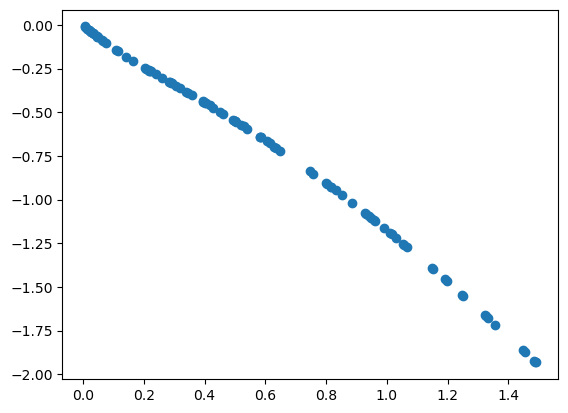

In [ ]:
# create a stick and test the sampling
stick = Stick(2,3,np.array([0,0]))
Xs = stick.sample(100)
plt.scatter(Xs[:,0],Xs[:,1])

In [ ]:
#|export
import random
import numpy as np
class Branch():
    def __init__(
        self,
        dimension,
        polynomial_degree=4,
        max_branches=5,
        path_length = 5,
        seed = None,
    ):
        store_attr()
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)

        self.sticks = [
            Stick(
                dimension,
                polynomial_degree,
                np.zeros(dimension)
            )
        ]
        self.branching_nums = [np.random.randint(1,max_branches)]
        stick_idx = 0
        for i in range(path_length):
            # go through all sticks after stick_idx and create new sticks at their ends
            new_stick_idx =len(self.sticks)
            for j in range(stick_idx,len(self.sticks)):
                num_new_sticks = self.branching_nums[j]
                for k in range(num_new_sticks):
                    # create a stick
                    stick = Stick(
                        dimension,
                        polynomial_degree,
                        self.sticks[j].end_point(),
                    )
                    self.sticks.append(stick)
                    self.branching_nums.append(
                        np.random.randint(1,max_branches)
                    )
            stick_idx = new_stick_idx
    def sample(self,n_samples=5000):
        Xs = []
        for stick in self.sticks:
            Xs.append(stick.sample(n_samples))
        return np.concatenate(Xs,axis=0)

In [ ]:
branch = Branch(3, path_length=2)
Xs = branch.sample(1000)
plot_3d(Xs, use_plotly=True)

In [ ]:
len(branch.sticks)

15